#  Model tuning and hyperparameter optimization

<i>Balázs Kégl (CNRS / PS-CDS) and Alex Gramfort (Inria)</i>

## Introduction
Virtually all learning models come with a set of parameters that should be tuned. To distinguish them from the parameters of the models set during training (learned parameters like neural weigths, tree cuts, or ensemble coefficients), we call them <i>hyperparameters</i>. Typical examples are the number of iterations and the tree depth in random forests, or the <code>C</code> or <code>gamma</code> of a support vector classifier. Scikit-learn has default values for all these parameters, but there is no guarantee that any of the classifiers perform optimally (or even close to optimally) using these default parameters. Worse: the optimal parameters vary depending on the data set, so tuning them is the task of the analyst, not the task of the provider of the library.

Hyperparameters come in all shapes and types. Some of them are crucial to be tuned (like <code>n_estimators</code> in ensemble methods), the default value of some others works fine most of the time (say, <code>min_samples_split</code> of a random forest). Scikit-learn also has auxiliary parameters that have no effects on the model (such as <code>verbose</code>), so knowing which parameters to tune requires understanding a little bit what the particular model is about. Most of the hyperparameters have typical ranges, although they can depend of course on the characteristics of the data set. There are even so called <i>conditional</i> hyperparameters whose <i>existence</i> depend on the value of some other hyperparameters: for example, when you add a new layer to a neural network, suddenly you have 3-5 new hyperparameters to tune.

Important hyperparameters can usually be interpreted as complexity parameters of the learned function. Sometimes the link is easy to see: an ensemble with a large number of deep trees have more degrees of freedom than a small ensemble of small trees. Sometimes the link between hyperparameters and complexity is more indirect, and understanding it requires some basic notion of <i>regularization</i>. One general notion that helps to understand the behavior of the learning algorithms with respect to their hyperparameters is <i>overfitting</i> and <i>underfitting</i> (this is why it is important to understand whether complexity increases or decreases as the hyperparameter grows). Let us call the model that we could obtain if we knew the distribution (or had infinite data) the <i>ideal</i> model. The goal of learning is to get as close to this model as possible, using only a finite training set. We may have two problems
<ol>
<li>
Underfitting occurs when our model is not flexible enough to pick up the details of the ideal function, so even with infinite data we could not get close to the ideal function. The difference between the error of the ideal function and the error of the best function we could pick from our model class (parametrized by the hyperparameters) is the <i>approximation</i> error. Underfitting means that the approximation error is larger than optimal. Increasing the complexity of the model class decreases the approximation error (independently of the data set).
<li>
Overfitting occurs when our model is too flexible so it learns the training data "by heart" and does not generalize well to unseen test data. The difference between the error of the function (learned on the data set) and the error of the best function we could pick from our model class (parametrized by the hyperparameters) is the <i>estimation</i> error. Overfitting means that estimation error is larger than optimal. Increasing the complexity of the model class (while keeping the data set fixed) increases the estimation error.
</ol>
Note the crucial difference between the two notions: the level of underfitting is independent of the data set; it only depends on the data distribution and the function set (parametrized by the hyperparameters), whereas the level of overfitting, of course, depends on the data set. Here are some general rules that could guide you in this landscape.
<ol>
<li> Overfitting increases as the model complexity grows.
<li> Overfitting increases as the data complexity (for example, the number of features) grows.
<li> Overfitting decreases as the data size grows.
</ol>

If we could compute the data distribution or had access to an infinite data set we could determine the estimation and approximation errors and set the model complexity to minimize their sum. Of course, this is impossible so these notions are not constructive (but can help you to understand the underlying phenomena). In practice, we <i>estimate</i> the <i>generalization</i> error (the sum of the approximation and estimation errors) on a held out (validation) set. The pragmatics of hyperparameter optimization are thus relatively simple: find the hyperparameters that minimize the validation error. The practical difficulties are the following:
<ol>
<li> Our estimate has a variance: it is based on a finite validation set. Optimizing a "noisy" function can be tricky. Using cross validation schemes makes this even worse: since training and test sets overlap, complex correlation structures are introduced into the error estimates.
<li> Evaluating the validation error at a vector of hyperparameter values requires training a model which may be slow. 
<li> The number of hyperparameter combinations increases exponentially with the number of hyperparameters.
</ol> 

The first step of hyperparameter tuning is usually trial and error. Try some combinations and look at how the error behaves. Once you have a "feeling" about what range should be explored and the sensitivity of the error to the hyperparameters, you can do a grid search (using either <code>GridSearchCV</code> from scikit learn, or by coding it). In this notebook we coded a simple grid search so you understand how it works. Once the number of hyperparameters is large (say, larger than 2) grid search will become increasingly time consuming. The main inefficency is a result of it not being intelligent: it will exhaustively look at <i>all</i> combinations, even those that are "trivially" bad. 

The main principle to improve on grid search is smoothness in the hyperparameter space: we assume that models with similar hyperparameters are not very different. This allows sophisticated automatic methods to direct the search toward promising regions while also keeping exploring unexplored regions. Most of these methods are based on <a href="http://en.wikipedia.org/wiki/Bayesian_optimization">Bayesian optimization</a>. We will work with the <a href="https://github.com/hyperopt/hyperopt/wiki/FMin">hyperopt</a> package. It can be installed with:

<code>pip install hyperopt</code>

In [1]:
# !pip install hyperopt

## Import some libraries

In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn

## Fetch the data and load it in pandas, and convert it into numpy
We can use any data set here. By the end of this section, two numpy arrays, <code>X</code> and <code>y</code> shoud be created.

In [27]:
data = pd.read_csv("train.csv", index_col=0)
data['real_period'] = data['period'] / data['div_period']
data.head(3)

,patch_id,star_id_b,star_id_r,magnitude_b,magnitude_r,asc_d,asc_m,asc_s,dec_d,dec_m,dec_s,period,frequency,num_points_good_b,num_points_good_r,asym_b,asym_r,log_p_not_variable,sigma_flux_b,sigma_flux_r,type,quality,div_period,real_period
54_3198,54.0,3198.0,3327.0,19.0780,18.1298,5.0,48.0,19.58,-70.0,36.0,16.84,0.610837,1.637100,123.0,122.0,2.61765,0.794118,-2.76059,41.4272,88.0977,3.0,2.0,1.0,0.610837
578_2223,578.0,2223.0,2598.0,19.0282,18.8067,5.0,5.0,52.85,-69.0,8.0,40.12,1.913020,0.522734,119.0,120.0,1.12500,0.600000,-2.23733,39.5553,45.3581,3.0,2.0,6.0,0.318837
242_3046,242.0,3046.0,3274.0,17.8534,15.6034,5.0,31.0,26.46,-69.0,14.0,32.21,0.996323,1.003690,102.0,97.0,1.37209,1.365850,-3.58045,118.8270,939.3540,3.0,1.0,1.0,0.996323


In [28]:
X = data[['magnitude_b', 'magnitude_r', 'real_period']].values
y = data['type'].values

In [29]:
X.shape, y.shape, X.dtype, y.dtype

((3641, 3), (3641,), dtype('float64'), dtype('float64'))

We're good !

## Train a classifier

without worrying too much about hyperparameters

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

clf = RandomForestClassifier(n_estimators=100, max_depth=8)
cv = KFold(n_splits=5, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
print("Accuracy: {:.4f} +/-{:.4f}".format(np.mean(scores), np.std(scores)))

Accuracy: 0.9154 +/-0.0136


### Train a classifier using a grid of hyperparameters

In [8]:
n_estimators_list = [2, 3, 5, 10, 20, 30, 50, 100, 200, 500]
max_depth_list = [1, 2, 3, 5, 7, 10, 15, 20, 30]
accuracies = {}
accuracy_stds = {}

for n_estimators in n_estimators_list:
    print(n_estimators)
    for max_depth in max_depth_list:
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=1)
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=3)
        accuracies[(n_estimators, max_depth)] = np.mean(scores)
        accuracy_stds[(n_estimators, max_depth)] = np.std(scores)

2
3
5
10
20
30
50
100
200
500


In [9]:
accuracies

{(2, 1): 0.74120879120879124,
 (2, 2): 0.81923076923076921,
 (2, 3): 0.87417582417582407,
 (2, 5): 0.87857142857142845,
 (2, 7): 0.87032967032967046,
 (2, 10): 0.84230769230769231,
 (2, 15): 0.84175824175824177,
 (2, 20): 0.84285714285714286,
 (2, 30): 0.84285714285714286,
 (3, 1): 0.77527472527472518,
 (3, 2): 0.85109890109890107,
 (3, 3): 0.86373626373626367,
 (3, 5): 0.89890109890109893,
 (3, 7): 0.88736263736263721,
 (3, 10): 0.89230769230769236,
 (3, 15): 0.88681318681318688,
 (3, 20): 0.89230769230769236,
 (3, 30): 0.89230769230769236,
 (5, 1): 0.76208791208791204,
 (5, 2): 0.85109890109890107,
 (5, 3): 0.88406593406593414,
 (5, 5): 0.90274725274725276,
 (5, 7): 0.90714285714285714,
 (5, 10): 0.90879120879120878,
 (5, 15): 0.9054945054945055,
 (5, 20): 0.90879120879120878,
 (5, 30): 0.90879120879120878,
 (10, 1): 0.74450549450549453,
 (10, 2): 0.85329670329670326,
 (10, 3): 0.89340659340659345,
 (10, 5): 0.9054945054945055,
 (10, 7): 0.90384615384615385,
 (10, 10): 0.909890109890

In [10]:
np.max(list(accuracies.values()))

0.91978021978021973

Now let's do it using scikit-learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">GridSearchCV</a> object.

In [11]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'n_estimators': n_estimators_list, 'max_depth': max_depth_list}
clf = RandomForestClassifier(random_state=42)

gs = GridSearchCV(clf, tuned_parameters, cv=cv, scoring='accuracy', n_jobs=3)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_estimators': [2, 3, 5, 10, 20, 30, 50, 100, 200, 500], 'max_depth': [1, 2, 3, 5, 7, 10, 15, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [12]:
print("Best parameters set found on development set:")
print(gs.best_params_)
print()
print("Grid scores on training set:")
print()
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:
{'n_estimators': 100, 'max_depth': 20}
()
Grid scores on training set:
()
0.776 (+/-0.018) for {'n_estimators': 2, 'max_depth': 1}
0.768 (+/-0.020) for {'n_estimators': 3, 'max_depth': 1}
0.810 (+/-0.018) for {'n_estimators': 5, 'max_depth': 1}
0.774 (+/-0.019) for {'n_estimators': 10, 'max_depth': 1}
0.775 (+/-0.022) for {'n_estimators': 20, 'max_depth': 1}
0.769 (+/-0.012) for {'n_estimators': 30, 'max_depth': 1}
0.770 (+/-0.015) for {'n_estimators': 50, 'max_depth': 1}
0.770 (+/-0.012) for {'n_estimators': 100, 'max_depth': 1}
0.771 (+/-0.011) for {'n_estimators': 200, 'max_depth': 1}
0.771 (+/-0.011) for {'n_estimators': 500, 'max_depth': 1}
0.885 (+/-0.020) for {'n_estimators': 2, 'max_depth': 2}
0.880 (+/-0.020) for {'n_estimators': 3, 'max_depth': 2}
0.873 (+/-0.015) for {'n_estimators': 5, 'max_depth': 2}
0.829 (+/-0.046) for {'n_estimators': 10, 'max_depth': 2}
0.807 (+/-0.035) for {'n_estimators': 20, 'max_depth': 2}
0.806 (+/-0.0

In [13]:
cv_results = pd.DataFrame(gs.cv_results_)
cv_results.head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.013881,0.002632,0.775611,0.777671,1,2,"{u'n_estimators': 2, u'max_depth': 1}",82,0.790123,0.773695,0.782967,0.776862,0.769231,0.780295,0.767857,0.777206,0.767857,0.780295,0.003265,0.000590,0.009229,0.002468
1,0.021396,0.003766,0.767921,0.770667,1,3,"{u'n_estimators': 3, u'max_depth': 1}",90,0.776406,0.767170,0.782967,0.776862,0.758242,0.768967,0.758242,0.765877,0.763736,0.774459,0.001953,0.000608,0.010032,0.004262
2,0.032885,0.005901,0.809942,0.811041,1,5,"{u'n_estimators': 5, u'max_depth': 1}",79,0.823045,0.808379,0.815934,0.810161,0.809066,0.811878,0.803571,0.810161,0.798077,0.814624,0.000425,0.000182,0.008830,0.002106
3,0.049651,0.008640,0.774238,0.776160,1,10,"{u'n_estimators': 10, u'max_depth': 1}",84,0.792867,0.774725,0.773352,0.768623,0.769231,0.780295,0.767857,0.776862,0.767857,0.780295,0.011606,0.002127,0.009536,0.004326
4,0.093227,0.014822,0.775062,0.776092,1,20,"{u'n_estimators': 20, u'max_depth': 1}",83,0.792867,0.774725,0.782967,0.774116,0.769231,0.779609,0.765110,0.774116,0.765110,0.777892,0.022935,0.003086,0.011062,0.002249


In [14]:
cv_results[['mean_test_score', 'param_max_depth', 'param_n_estimators']].head(15)

,mean_test_score,param_max_depth,param_n_estimators
0,0.775611,1,2
1,0.767921,1,3
2,0.809942,1,5
3,0.774238,1,10
4,0.775062,1,20
5,0.769294,1,30
6,0.770393,1,50
7,0.769569,1,100
8,0.771217,1,200
9,0.770942,1,500


In [15]:
cv_results[['mean_test_score', 'param_max_depth', 'param_n_estimators']].sort_values(by='mean_test_score', ascending=False).head()

,mean_test_score,param_max_depth,param_n_estimators
77,0.920626,20,100
87,0.920077,30,100
69,0.919253,15,500
65,0.918704,15,30
68,0.918704,15,200


### Plot some learning curves

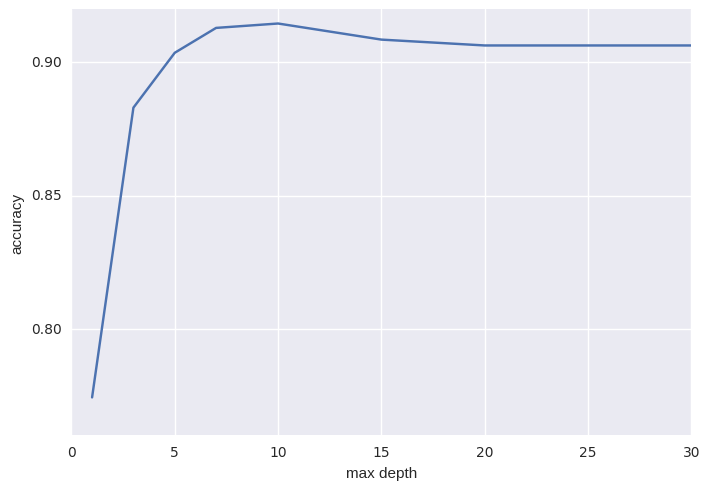

In [32]:
this_cv_results = cv_results[cv_results['param_n_estimators'] == 10]
plt.errorbar(this_cv_results['param_max_depth'],
             this_cv_results['mean_test_score']);
plt.xlabel('max depth')
plt.ylabel('accuracy');

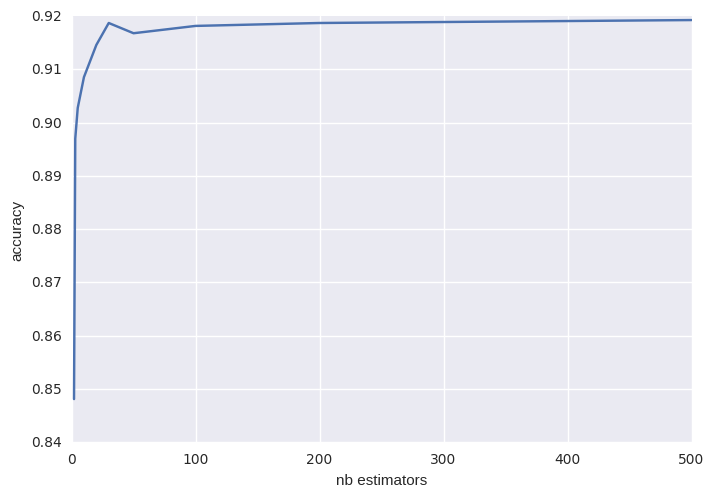

In [33]:
this_cv_results = cv_results[cv_results['param_max_depth'] == 15]
plt.errorbar(this_cv_results['param_n_estimators'],
             this_cv_results['mean_test_score']);
plt.xlabel('nb estimators')
plt.ylabel('accuracy');

## Now let's automate the search

All wrapper-type hyperparameter optimization will need a function with a parameter that represents the hyperparameter, and which returns a score (usually to be minimized). The following function thus trains a random forest classifier with two hyperparameters, stored in a pair <code>x_int</code>.

In [23]:
i = 0

def objective(params):
    global i
    i += 1
    print(params)
    clf = RandomForestClassifier(n_estimators=300,
                                 max_depth=int(params['max_depth']),
                                 max_features=params['max_features'])
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=3)
    score = np.mean(scores)
    print("SCORE: %s" % score)
    df_result_hyperopt.loc[i, ['score'] + list(params.keys())] = \
        [score] + list(params.values())
    return {'loss': 1. - score, 'status': STATUS_OK}

In [24]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

space = {
    'max_depth': hp.quniform('max_depth', 2, 30, 1),
    'max_features': hp.quniform('max_features', 0.7, 1, 0.05)
}

df_result_hyperopt = pd.DataFrame(
    columns=['score'] + list(space.keys()))

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=15, trials=trials)

print("Best: %s" % best)

{'max_features': 0.75, 'max_depth': 11.0}
SCORE: 0.915384615385
{'max_features': 0.75, 'max_depth': 14.0}
SCORE: 0.915934065934
{'max_features': 0.9500000000000001, 'max_depth': 3.0}
SCORE: 0.896703296703
{'max_features': 0.8500000000000001, 'max_depth': 19.0}
SCORE: 0.915384615385
{'max_features': 0.75, 'max_depth': 12.0}
SCORE: 0.914835164835
{'max_features': 0.9, 'max_depth': 5.0}
SCORE: 0.903846153846
{'max_features': 0.9500000000000001, 'max_depth': 17.0}
SCORE: 0.915934065934
{'max_features': 0.7000000000000001, 'max_depth': 15.0}
SCORE: 0.915384615385
{'max_features': 0.9500000000000001, 'max_depth': 16.0}
SCORE: 0.915384615385
{'max_features': 0.8500000000000001, 'max_depth': 12.0}
SCORE: 0.914835164835
{'max_features': 0.75, 'max_depth': 28.0}
SCORE: 0.915384615385
{'max_features': 0.9500000000000001, 'max_depth': 27.0}
SCORE: 0.915384615385
{'max_features': 0.75, 'max_depth': 18.0}
SCORE: 0.915384615385
{'max_features': 0.9500000000000001, 'max_depth': 24.0}
SCORE: 0.91538461

In [25]:
df_result_hyperopt.sort_values(by='score', ascending=False).head(10)

,score,max_features,max_depth
2,0.915934,0.75,14
7,0.915934,0.95,17
1,0.915385,0.75,11
4,0.915385,0.85,19
8,0.915385,0.7,15
9,0.915385,0.95,16
11,0.915385,0.75,28
12,0.915385,0.95,27
13,0.915385,0.75,18
14,0.915385,0.95,24
